In [1]:
#Replacing a Black-box model by a Global Single Tree Approximation
#A regression case - Violent Crime
#Laurent Deborde 2019 march 24th

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import random as rd

In [3]:
# load the data (violent crime usual data less crime stats + columns names)
# data source is http://archive.ics.uci.edu/ml/datasets/communities+and+crime
#Creator: Michael Redmond (redmond '@' lasalle.edu); Computer Science; La Salle University; Philadelphia, PA, 19141, USA 
#-- culled from 1990 US Census, 1995 US FBI Uniform Crime Report, 1990 US Law Enforcement Management and Administrative Statistics Survey, available from ICPSR at U of Michigan. 
#-- Donor: Michael Redmond (redmond '@' lasalle.edu); Computer Science; La Salle University; Philadelphia, PA, 19141, USA 
#-- Date: July 2009

In [4]:
d=pd.read_excel('VCrimeU_C.xls')

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 127 entries, communityname to nonViolPerPop
dtypes: float64(110), int64(16), object(1)
memory usage: 2.1+ MB


In [6]:
d.columns

Index(['communityname', 'population', 'householdsize', 'racepctblack',
       'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21',
       'agePct12t29', 'agePct16t24',
       ...
       'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop'],
      dtype='object', length=127)

In [7]:
d.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2.215000e+03,2205.000000,2193.000000,2215.000000,2197.000000,2200.000000,2215.000000,2215.000000,2212.000000,2207.000000,...,2215.000000,2062.000000,343.000000,3.430000e+02,343.000000,92.0,324.000000,3.430000e+02,1993.000000,2118.000000
mean,5.311798e+04,2.706907,9.402303,83.979819,2.668411,7.983927,14.445837,27.644840,13.982794,11.857096,...,2783.835034,3.244952,185.478134,3.217602e+07,87.130933,10.0,6.568086,1.535779e+05,589.374496,4908.241804
std,2.046203e+05,0.333732,14.300521,16.419080,4.487139,14.632392,4.518623,6.181517,5.971151,4.771670,...,2828.993341,5.024095,318.542834,1.104566e+08,10.349612,0.0,4.397051,2.030409e+05,614.797082,2739.708901
min,1.000500e+04,1.600000,0.010000,2.680000,0.030000,0.120000,4.580000,9.380000,4.640000,1.660000,...,10.000000,0.020000,20.000000,2.380215e+06,10.850000,10.0,0.440000,1.526040e+04,5.350000,116.790000
25%,1.436600e+04,2.500000,0.850000,76.320000,0.610000,0.920000,12.250000,24.415000,11.320000,8.785000,...,1181.900000,0.490000,54.000000,7.275060e+06,84.295000,10.0,4.010000,8.809435e+04,161.730000,2918.070000
50%,2.279200e+04,2.650000,2.880000,90.350000,1.230000,2.185000,13.620000,26.780000,12.550000,11.760000,...,2027.300000,1.390000,86.000000,1.116411e+07,89.580000,10.0,5.600000,1.145820e+05,374.070000,4425.450000
75%,4.302400e+04,2.840000,11.430000,96.225000,2.660000,7.880000,15.360000,29.205000,14.350000,14.420000,...,3321.700000,3.560000,189.500000,2.014754e+07,93.200000,10.0,7.870000,1.556557e+05,794.410000,6229.280000
max,7.322564e+06,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,70.510000,63.620000,52.770000,...,44229.900000,54.330000,3187.000000,1.617293e+09,99.940000,10.0,48.440000,2.422367e+06,4877.060000,27119.760000


In [8]:
#we won't use the nonViolentCrime column 
d=d.drop('nonViolPerPop',axis=1)

In [9]:
#drop points for which the target is unknown
d=d.dropna(subset={'ViolentCrimesPerPop'})

In [10]:
#for the sake of simplicity we will drop line and columns with too many missing values 

In [11]:
#drop community name (not an index as its repeated)
d=d.drop('communityname',axis=1)

In [12]:
# drop columns with too many missing values
d=d.drop('numbUrban',axis=1)
d=d.drop('pctUrban',axis=1)
d1=d
for colonne in d.columns:
    if d[colonne].isnull().sum() > 1000:
        d1=d1.drop(colonne,axis=1)

In [13]:
#for the sake drop lines with missing values 
d1=d1.dropna()

In [14]:
d1.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,MedOwnCostPctIncNoMt,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
count,1.050000e+03,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,...,1050.000000,1050.000000,1050.00000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,6.408722e+04,2.703981,11.220505,80.778552,3.023848,9.593867,14.502476,28.288019,14.313457,11.577676,...,13.026095,8.292000,58.64019,49.441638,76.080390,86.820752,36.714667,3010.049143,3.422019,687.176371
std,1.522935e+05,0.337810,15.086994,17.167271,4.748110,15.156706,4.131349,5.821422,5.561958,4.689792,...,1.478581,9.081596,16.75484,10.155655,10.530017,7.766938,155.324683,3142.959621,5.374771,658.052239
min,1.012900e+04,1.880000,0.100000,7.210000,0.120000,0.260000,5.290000,10.550000,4.930000,1.660000,...,10.100000,0.410000,7.85000,15.100000,30.330000,40.400000,0.900000,10.000000,0.020000,5.350000
25%,1.921400e+04,2.500000,1.225000,71.522500,0.750000,1.110000,12.390000,25.180000,11.682500,8.562500,...,11.900000,2.492500,46.75250,42.510000,71.175000,83.547500,9.100000,1315.250000,0.490000,227.622500
50%,3.099400e+04,2.640000,4.580000,86.445000,1.425000,3.085000,13.760000,27.315000,12.900000,11.500000,...,12.800000,4.960000,60.14500,49.850000,77.865000,88.920000,17.350000,2169.600000,1.465000,462.140000
75%,5.691550e+04,2.830000,15.352500,94.417500,3.085000,10.865000,15.470000,29.810000,14.895000,14.117500,...,13.700000,10.547500,72.47750,56.500000,83.370000,92.127500,31.150000,3398.425000,3.650000,919.220000
max,3.485398e+06,5.280000,89.950000,99.280000,45.190000,93.870000,50.800000,70.510000,63.620000,52.770000,...,23.400000,59.720000,91.12000,75.700000,95.810000,97.730000,3569.800000,44229.900000,52.590000,4026.590000


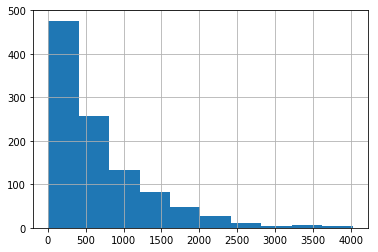

In [15]:
d1['ViolentCrimesPerPop'].hist()

In [16]:
#separate the target and spilt between train and test
y=d1['ViolentCrimesPerPop']
X=d1.drop('ViolentCrimesPerPop',axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## let's try to find a simple tree model

In [17]:
param_grid = {'max_depth': range(1,15)}
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_depth': 3}
Best cross-validation score: 0.47
Test set score: 0.46


In [19]:
### fit that tree on the whole training set
k=3
tree = DecisionTreeRegressor(max_depth=k)
tree.fit(X_train,y_train)
R2_appr=tree.score(X_train,y_train)
R2_test=tree.score(X_test,y_test)
print('for depth',k)
print("R2 on training set is {:.2f}".format(R2_appr))
print("R2 on test is {:.2f}".format(R2_test))

for depth 3
R2 on training set is 0.67
R2 on test is 0.46


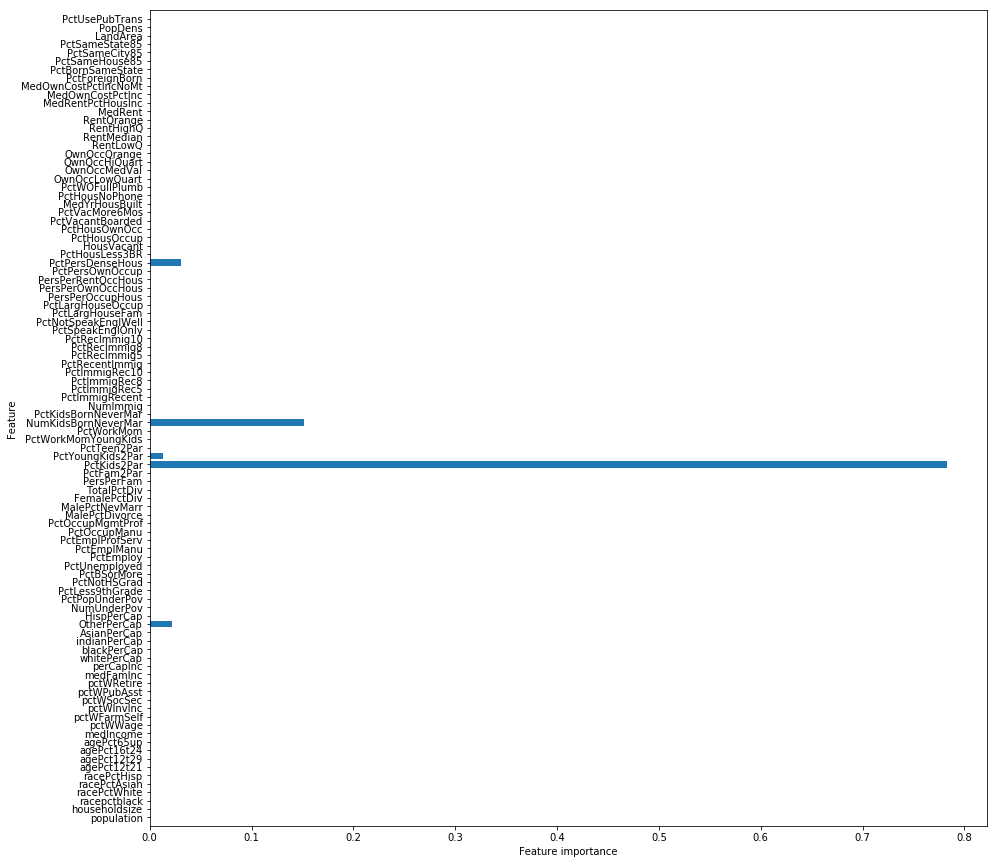

In [20]:
# adapted from Muller & Guido 
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

def plot_feature_importances(model, Frame):
    plt.clf()
    n_features=len(Frame.columns)
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Frame.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


plot_feature_importances(tree,X_train)
plt.show()  

### Let's try a more complex model : Random forest

### with default parameters

In [21]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor()
np.set_printoptions(precision=3)
rdf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
print("R2 in sample {:.2f}".format(rdf.score(X_train,y_train)))
print("R2 out of sample {:.2f}".format(rdf.score(X_test,y_test)))

R2 in sample 0.93
R2 out of sample 0.64


### It's more efficient than the single tree. Let's also try Gradient Boosting

### with default parameters

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
gbr = GradientBoostingRegressor()
np.set_printoptions(precision=3)
gbr.fit(X_train,y_train)
print("le R2 in sample est de {:.2f}".format(gbr.score(X_train,y_train)))
print("et le R2 out of sample est de {:.2f}".format(gbr.score(X_test,y_test)))

le R2 in sample est de 0.93
et le R2 out of sample est de 0.64


### Quite good. Let's suppose we are not allowed to use those complex black box models. We will try to use the knowledge gained from those models to build a more efficient single tree. In order to achieve that, we will generate additionnal unlabeled data. We will then use the black box as a oracle to label those data, and train a tree on the new data. 

### First let's genereate additionnal (unlabeled) data, similar to the data from the training set. We wil draw randomly those points from a multivariate gaussian distribution estimated on the training set (we didn't perform test to verify that the initial data distribution is indeed more or less gaussian. If our approach fail then we will have a look at the actual training set to decide another distribution to use). 

In [25]:
# estimate mean and variance on the training set
echmean=X_train.mean(axis=0)
echcov= X_train.cov()

In [26]:
# randomly draw points according to a multivariate distribution with such parameters
X_virt= np.random.multivariate_normal(echmean, echcov, 10000)

D:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


In [27]:
print(X_virt.shape)

(10000, 96)


In [28]:
d_virt=pd.DataFrame(X_virt, columns=X_train.columns)
d_virt.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,MedOwnCostPctInc,MedOwnCostPctIncNoMt,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,65286.899801,2.705189,11.223482,80.959316,3.050037,9.234383,14.641870,28.508432,14.540260,11.603203,...,21.322055,13.062470,8.116525,59.659268,49.723849,76.368519,87.090700,38.492290,3016.312717,3.580865
std,122393.382986,0.350806,15.096912,17.401953,4.976185,15.114947,4.329211,6.052823,5.846105,4.674926,...,2.925560,1.471274,8.924360,16.470827,10.210405,10.627717,7.674620,149.324012,2925.891350,5.579010
min,-425469.713410,1.437954,-44.610353,12.250288,-20.117234,-44.837147,-5.926748,2.369296,-11.155950,-5.101991,...,11.061401,7.615556,-24.957658,-2.269292,8.444875,39.357428,60.114340,-510.136698,-6439.029030,-18.754101
25%,-15231.243243,2.469789,1.213672,69.224748,-0.363556,-0.977807,11.691286,24.453643,10.615882,8.492512,...,19.362592,12.053353,2.091160,48.416151,42.978870,69.123137,81.905457,-61.332256,1050.244447,-0.235367
50%,64829.469475,2.702402,11.200389,81.023803,3.108073,9.167715,14.613882,28.487128,14.527183,11.585231,...,21.310971,13.078070,8.070684,59.581449,49.791966,76.476972,87.061897,41.204221,2997.333403,3.509201
75%,146922.489843,2.941927,21.356410,92.700863,6.407310,19.318710,17.526209,32.593320,18.517278,14.758291,...,23.286651,14.059483,14.054191,70.727360,56.545558,83.465946,92.378882,138.374650,5001.855690,7.344698
max,503157.069234,3.988976,63.035459,146.251112,20.562509,65.169204,31.048973,50.841610,36.414556,30.635049,...,34.607061,18.796918,41.098765,117.096772,86.430539,119.331194,116.291601,579.717013,14437.615871,24.011038


#### Label the new data using the Gradient Boosting as an oracle

In [29]:
y_virt=gbr.predict(d_virt)
print(y_virt)

[ 932.367 1340.127 1386.808 ... 1005.02   833.113 1255.215]


### Let's try to train a tree on these virtual data (we don't bother to add the original real training set since its much smaller than the virtual set)

In [32]:
for i in range (3,12):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    score=cross_val_score(tree,d_virt,y_virt,cv=5).mean() 
    print("k=",i,"average cross-validation score: {:.3f}".format(score))

k= 3 average cross-validation score: 0.668
k= 4 average cross-validation score: 0.732
k= 5 average cross-validation score: 0.780
k= 6 average cross-validation score: 0.809
k= 7 average cross-validation score: 0.827
k= 8 average cross-validation score: 0.832
k= 9 average cross-validation score: 0.828
k= 10 average cross-validation score: 0.821
k= 11 average cross-validation score: 0.816


###  Is our new single tree a good predictor ? Let's check on the test set

In [33]:
# optimum is at k=8
k=8
tree = DecisionTreeRegressor(max_depth=k)
tree.fit(d_virt,y_virt)
R2_appr=tree.score(X_train,y_train)
R2_test=tree.score(X_test,y_test)
print('for depth',k)
print("R2 on training set is {:.2f}".format(R2_appr))
print("R2 on test is {:.2f}".format(R2_test))

for depth 8
R2 on training set is 0.68
R2 on test is 0.52


### Yes it is ! The impromvement over the initial tree is quite significant : the R2 is halfway between the initial tree and the Gradient Boosting.

### Let's see if the method also function with the Random Forest

In [34]:
z_virt=rdf.predict(d_virt)

In [35]:
for i in range (3,12):
    tree1 = DecisionTreeRegressor(max_depth=i,random_state=42)
    score=cross_val_score(tree1,d_virt,z_virt,cv=5).mean() 
    print("k=",i,"average cross-validation score: {:.3f}".format(score))

k= 3 average cross-validation score: 0.788
k= 4 average cross-validation score: 0.839
k= 5 average cross-validation score: 0.860
k= 6 average cross-validation score: 0.871
k= 7 average cross-validation score: 0.875
k= 8 average cross-validation score: 0.876
k= 9 average cross-validation score: 0.869
k= 10 average cross-validation score: 0.862
k= 11 average cross-validation score: 0.852


In [36]:
# optimum is k=8
k=8
tree1 = DecisionTreeRegressor(max_depth=k)
tree1.fit(d_virt,y_virt)
R2_appr=tree1.score(X_train,y_train)
R2_test=tree1.score(X_test,y_test)
print('pour une profondeur de',k)
print("le R2 sur l'échantillon d'apprentissage original est de {:.2f}".format(R2_appr))
print("et le R2 sur le vrai échantillon de test est de {:.2f}".format(R2_test))

pour une profondeur de 8
le R2 sur l'échantillon d'apprentissage original est de 0.68
et le R2 sur le vrai échantillon de test est de 0.54


### Very good also !

## For illustration purpose, let's reapply the same method with a dimensionality reduction through Principal Component Analysis (PCA). That's not realy useful here as results are already quite good, put it may be in other cases of high dimensionality. 

In [37]:
# first normalise the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_s=scaler.fit_transform(X_train)
d_train = pd.DataFrame(X_s, columns=X_train.columns)
X_ts=scaler.transform(X_test)
d_test = pd.DataFrame(X_ts, columns=X_test.columns)

In [38]:
#retrain black box models on those scaled data
gbr = GradientBoostingRegressor()
gbr.fit(d_train,y_train)
print("R2 in sample {:.2f}".format(gbr.score(d_train,y_train)))
print("R2 out of sample {:.2f}".format(gbr.score(d_test,y_test)))

R2 in sample 0.93
R2 out of sample 0.64


In [39]:
rdf = RandomForestRegressor()
np.set_printoptions(precision=3)
rdf.fit(d_train,y_train)
print("R2 in sample {:.2f}".format(rdf.score(d_train,y_train)))
print("R2 out of sample {:.2f}".format(rdf.score(d_test,y_test)))

R2 in sample 0.92
R2 out of sample 0.58


In [40]:
#compute PCA
from sklearn.decomposition import PCA
pca=PCA().fit(d_train)

Text(0.5,1,'Variance explanation')

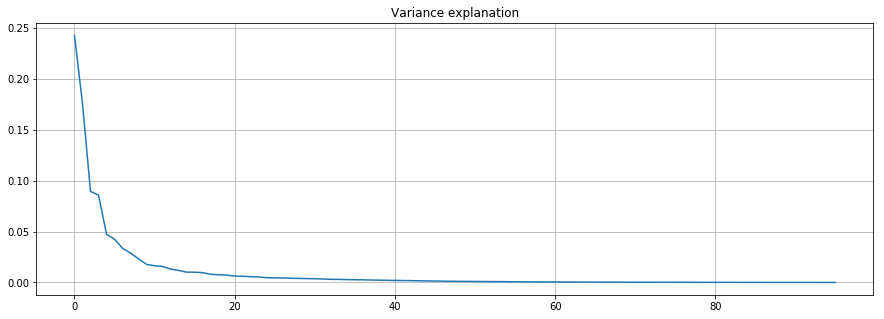

In [41]:
#look at explained variance
plt.close
expl=pca.explained_variance_ratio_
plt.figure(figsize=(15,5))
plt.plot(expl,label='variance explained by axe (%)')
plt.grid(True)
plt.title('Variance explanation')

Text(0,0.5,'Cumulative % of explained variance')

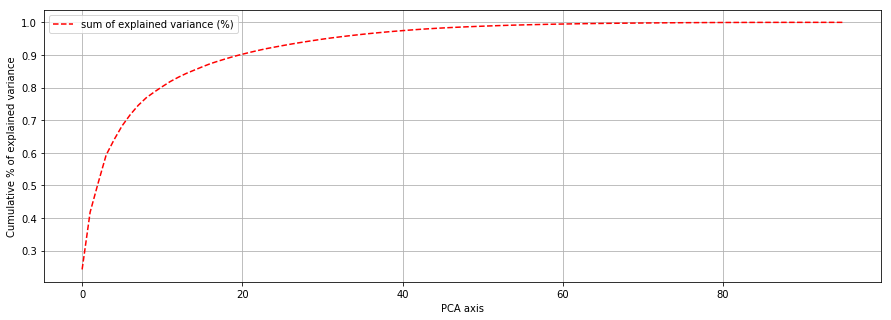

In [42]:
#on a cumulative basis
plt.close
expl1=expl
plt.figure(figsize=(15,5))
for i in range(1,len(expl1)):
        expl1[i]+=expl1[i-1]
plt.plot(expl1,'r--',label='sum of explained variance (%)')
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('PCA axis') 
plt.ylabel('Cumulative % of explained variance') 


In [43]:
print(pca.explained_variance_ratio_)

[0.243 0.418 0.508 0.593 0.641 0.683 0.717 0.746 0.769 0.786 0.803 0.819
 0.832 0.843 0.854 0.864 0.873 0.881 0.889 0.896 0.902 0.908 0.914 0.919
 0.924 0.929 0.933 0.937 0.941 0.945 0.949 0.952 0.955 0.958 0.961 0.963
 0.966 0.968 0.971 0.973 0.975 0.977 0.978 0.98  0.981 0.983 0.984 0.985
 0.986 0.987 0.988 0.989 0.99  0.991 0.992 0.992 0.993 0.993 0.994 0.994
 0.995 0.995 0.996 0.996 0.996 0.997 0.997 0.997 0.998 0.998 0.998 0.998
 0.998 0.999 0.999 0.999 0.999 0.999 0.999 0.999 1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]


### 32 axis explain more than 95% of the data variance, of which 21 more than 90% and 11 more than 80%. Let's reduce dimensionality to 32

#### Let's randomly draw points in the reduced 32 dimension space of the 32 first PCA axis rather than in the original 97-dimension feature space. Remark that as PCA axis are orthogonals, we can suppose the distribution of points in that subspace to be of covariances zeros. 

In [44]:
##### First refit the data on a 32 dimension PCA
pca1=PCA(n_components=32).fit(d_train)

In [45]:
#project points in that subspace
d_train_pca1=pca1.transform(d_train)
d_pca1 = pd.DataFrame(d_train_pca1)
d_pca1.describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,...,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02
mean,-3.103546e-18,-1.520738e-16,-9.874919e-17,4.739961e-17,1.235776e-16,-3.949968e-18,4.955093e-17,-1.869181e-17,4.542463e-17,9.099032e-18,...,-1.784539e-17,2.271231e-17,6.348162e-18,-3.209349e-18,-2.172482e-17,-1.721057e-17,3.498543e-17,8.323146e-18,-2.835512e-17,-2.680335e-18
std,4.829543e+00,4.108171e+00,2.930534e+00,2.872220e+00,2.132531e+00,2.020858e+00,1.796245e+00,1.662857e+00,1.492792e+00,1.304541e+00,...,7.399259e-01,7.180403e-01,6.685861e-01,6.596201e-01,6.512418e-01,6.311170e-01,6.137633e-01,6.025491e-01,5.924987e-01,5.705488e-01
min,-1.172739e+01,-6.837900e+00,-1.078367e+01,-9.851146e+00,-6.566511e+00,-5.630097e+00,-5.534597e+00,-5.377272e+00,-5.847839e+00,-4.220820e+00,...,-2.402373e+00,-2.794165e+00,-3.312178e+00,-2.876298e+00,-2.603783e+00,-2.997684e+00,-3.121349e+00,-2.071898e+00,-2.554884e+00,-2.658365e+00
25%,-3.383874e+00,-2.715486e+00,-1.866924e+00,-1.761198e+00,-1.407257e+00,-1.132063e+00,-1.084095e+00,-9.851366e-01,-8.612362e-01,-7.653992e-01,...,-4.347720e-01,-4.416907e-01,-3.712569e-01,-3.911435e-01,-3.575647e-01,-3.298733e-01,-3.299239e-01,-3.798457e-01,-3.687825e-01,-3.218174e-01
50%,-4.479176e-01,-1.068160e+00,-3.167401e-01,-1.435353e-01,-1.410793e-01,-1.346770e-01,-2.398832e-01,7.383530e-02,1.344746e-01,3.380179e-03,...,-4.786793e-02,-2.381192e-04,1.593879e-02,2.979886e-02,7.253283e-03,7.971905e-03,-2.473815e-02,-2.223623e-02,-2.856173e-02,-5.425368e-03
75%,2.922497e+00,1.438362e+00,1.777577e+00,1.487608e+00,1.295964e+00,9.472657e-01,9.222823e-01,8.966434e-01,1.044506e+00,7.206377e-01,...,3.597513e-01,4.312644e-01,3.870709e-01,3.831452e-01,3.813801e-01,3.548276e-01,3.492704e-01,3.493962e-01,3.476077e-01,3.210287e-01
max,1.634011e+01,2.379005e+01,1.094350e+01,1.651907e+01,8.795216e+00,1.962408e+01,1.061145e+01,1.166825e+01,6.450313e+00,7.003779e+00,...,6.403984e+00,2.804411e+00,3.746512e+00,4.084696e+00,3.212669e+00,3.806609e+00,4.284545e+00,2.114495e+00,2.704054e+00,3.217550e+00


In [46]:
#draw randomly points in the subspace, (covariance being zero, mean and variance being estimated on the (projected) dataset
echmean=d_pca1.mean(axis=0)
echmean[:]=0
echcov= d_pca1.cov()
echcov=echcov.values
for i in range(16):
    for j in range(16):
        if j!=i:
            echcov[i,j]=0
print(echcov)

[[ 2.332e+01  0.000e+00  0.000e+00 ... -4.403e-12  3.371e-13  5.555e-12]
 [ 0.000e+00  1.688e+01  0.000e+00 ... -8.933e-12  2.006e-11  3.951e-11]
 [ 0.000e+00  0.000e+00  8.588e+00 ... -2.546e-10  1.793e-10  7.931e-10]
 ...
 [-4.403e-12 -8.933e-12 -2.546e-10 ...  3.631e-01 -2.824e-05 -6.527e-05]
 [ 3.371e-13  2.006e-11  1.793e-10 ... -2.824e-05  3.511e-01  2.592e-04]
 [ 5.555e-12  3.951e-11  7.931e-10 ... -6.527e-05  2.592e-04  3.255e-01]]


In [47]:
nombre=10000
X_virt= np.random.multivariate_normal(echmean, echcov, nombre, check_valid ='warn')

In [48]:
#transform back the generated points in the whole original 97-dimension feature space
d_virt=pca1.inverse_transform(X_virt)

In [49]:
# ask the black box oracle (gradient boosting) for data labels
y_virt=gbr.predict(d_virt)

In [50]:
#train a simple tree on those virtual data
for i in range (6,13):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    score=cross_val_score(tree,d_virt,y_virt,cv=5).mean() 
    print("k=",i,"average cross-validation score: {:.3f}".format(score))

k= 6 average cross-validation score: 0.830
k= 7 average cross-validation score: 0.852
k= 8 average cross-validation score: 0.858
k= 9 average cross-validation score: 0.856
k= 10 average cross-validation score: 0.853
k= 11 average cross-validation score: 0.846
k= 12 average cross-validation score: 0.842


In [52]:
#see if the optimal tree is a good predictor of test (and train) sets
k=8
tree = DecisionTreeRegressor(max_depth=k)
tree.fit(d_virt,y_virt)
R2_appr=tree.score(d_train,y_train)
R2_test=tree.score(d_test,y_test)
print('for depth',k)
print("R2 on original training set is {:.2f}".format(R2_appr))
print("R2 on original test set is {:.2f}".format(R2_test))

for depth 8
R2 on original training set is 0.67
R2 on original test set is 0.53


#### Slightly better than without ACP

In [53]:
#### same process with Random Forest
# ask the black box oracle (random forest) for data labels
z_virt=rdf.predict(d_virt)
#train a simple tree on those virtual data
for i in range (6,13):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    score=cross_val_score(tree,d_virt,z_virt,cv=5).mean() 
    print("k=",i,"average cross-validation score: {:.3f}".format(score))

k= 6 average cross-validation score: 0.874
k= 7 average cross-validation score: 0.878
k= 8 average cross-validation score: 0.878
k= 9 average cross-validation score: 0.872
k= 10 average cross-validation score: 0.865
k= 11 average cross-validation score: 0.856
k= 12 average cross-validation score: 0.850


In [54]:
#see if the optimal tree is a good predictor of test (and train) sets
k=7
tree = DecisionTreeRegressor(max_depth=k)
tree.fit(d_virt,z_virt)
R2_appr=tree.score(d_train,y_train)
R2_test=tree.score(d_test,y_test)
print('pour une profondeur de',k)
print("le R2 sur l'échantillon d'apprentissage original est de {:.2f}".format(R2_appr))
print("et le R2 sur le vrai échantillon de test est de {:.2f}".format(R2_test))

pour une profondeur de 7
le R2 sur l'échantillon d'apprentissage original est de 0.64
et le R2 sur le vrai échantillon de test est de 0.60


####  Quite better than without PCA